<a href="https://colab.research.google.com/github/makhlufiaero338/tugas-robot/blob/main/w12/simulasi_Introduction_to_Localization_and_Filtering_Theory.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Helper functions
np.random.seed(42)
def generate_motion_data(steps=50, velocity=1, noise=0.2):
    positions = np.cumsum(np.ones(steps) * velocity + np.random.normal(0, noise, steps))
    return positions

def generate_sensor_data(true_positions, noise=0.5):
    return true_positions + np.random.normal(0, noise, len(true_positions))

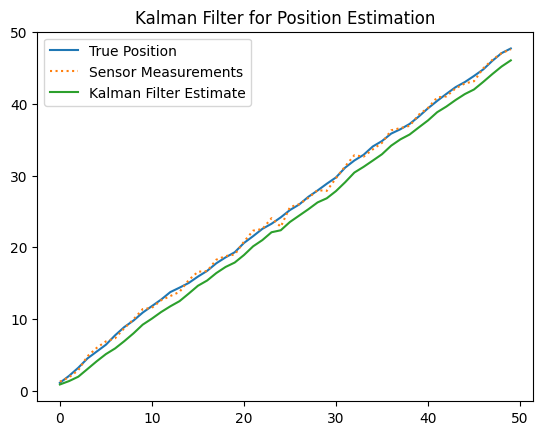

In [3]:
##########################
# Kalman Filter Simulation
##########################

class KalmanFilter:
    def __init__(self, process_variance, measurement_variance, initial_estimate, initial_uncertainty):
        self.q = process_variance
        self.r = measurement_variance
        self.x = initial_estimate
        self.p = initial_uncertainty

    def update(self, measurement):
        # Measurement update
        k = self.p / (self.p + self.r)  # Kalman gain
        self.x = self.x + k * (measurement - self.x)  # Update estimate
        self.p = (1 - k) * self.p  # Update uncertainty

    def predict(self):
        # Prediction step (in this case no explicit motion model)
        self.p += self.q  # Increase uncertainty due to process noise
        return self.x

true_positions = generate_motion_data()
measurements = generate_sensor_data(true_positions)

kf = KalmanFilter(process_variance=0.1, measurement_variance=0.5, initial_estimate=0, initial_uncertainty=1)
kf_positions = []

for z in measurements:
    kf.predict()
    kf.update(z)
    kf_positions.append(kf.x)

plt.plot(true_positions, label="True Position")
plt.plot(measurements, label="Sensor Measurements", linestyle='dotted')
plt.plot(kf_positions, label="Kalman Filter Estimate")
plt.legend()
plt.title("Kalman Filter for Position Estimation")
plt.show()


In [6]:
def particle_filter(true_positions, measurements, num_particles=100, sensor_noise=0.5):
    particles = np.random.uniform(min(true_positions), max(true_positions), num_particles)
    weights = np.ones(num_particles) / num_particles

    estimated_positions = []

    for z in measurements:
        # Update particles based on measurements
        weights *= np.exp(-0.5 * ((particles - z) / sensor_noise) ** 2)
        if np.sum(weights) == 0:  # Handle case where weights sum to zero
            weights = np.ones(num_particles) / num_particles
        else:
            weights /= np.sum(weights)

        # Resample particles
        indices = np.random.choice(range(num_particles), num_particles, p=weights)
        particles = particles[indices]
        weights = np.ones(num_particles) / num_particles

        # Estimate position
        estimated_positions.append(np.mean(particles))

    return estimated_positions


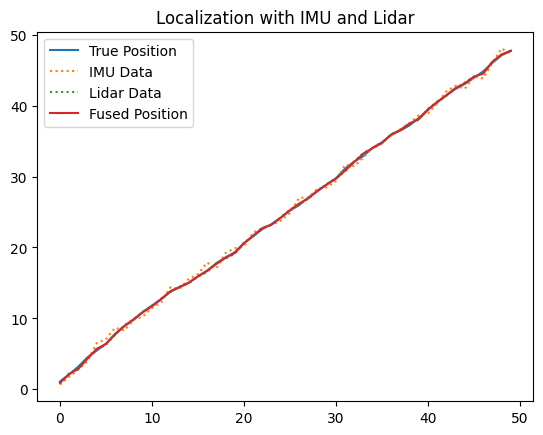

In [7]:
##########################
# Localization with IMU and Lidar
##########################
# Assuming data fusion from IMU and Lidar for noisy measurements
imu_noise = 0.5
lidar_noise = 0.2
imu_data = generate_sensor_data(true_positions, imu_noise)
lidar_data = generate_sensor_data(true_positions, lidar_noise)

fusion_data = (imu_data / imu_noise ** 2 + lidar_data / lidar_noise ** 2) / (1 / imu_noise ** 2 + 1 / lidar_noise ** 2)

plt.plot(true_positions, label="True Position")
plt.plot(imu_data, label="IMU Data", linestyle='dotted')
plt.plot(lidar_data, label="Lidar Data", linestyle='dotted')
plt.plot(fusion_data, label="Fused Position")
plt.legend()
plt.title("Localization with IMU and Lidar")
plt.show()

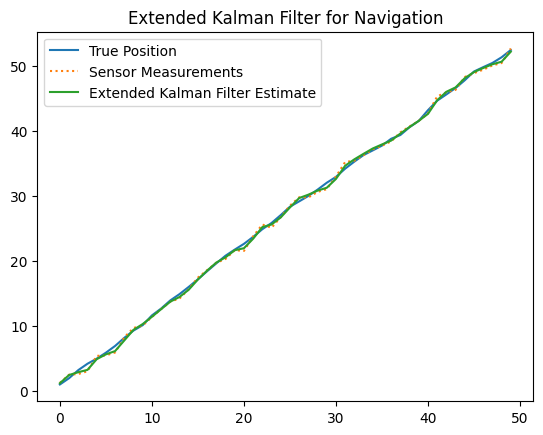

In [8]:
##########################
# Extended Kalman Filter Simulation for Navigation
##########################

class ExtendedKalmanFilter:
    def __init__(self, process_variance, measurement_variance):
        self.q = process_variance
        self.r = measurement_variance
        self.x = np.array([[0], [1]])  # State: [position, velocity]
        self.p = np.eye(2)  # Uncertainty matrix

    def predict(self):
        # State transition model
        F = np.array([[1, 1], [0, 1]])
        self.x = F @ self.x
        self.p = F @ self.p @ F.T + np.eye(2) * self.q

    def update(self, measurement):
        # Measurement model
        H = np.array([[1, 0]])
        z = np.array([[measurement]])
        y = z - H @ self.x  # Innovation
        S = H @ self.p @ H.T + self.r
        K = self.p @ H.T @ np.linalg.inv(S)
        self.x = self.x + K @ y
        self.p = (np.eye(2) - K @ H) @ self.p

true_positions = generate_motion_data()
measurements = generate_sensor_data(true_positions)
ekf = ExtendedKalmanFilter(process_variance=0.1, measurement_variance=0.5)

ekf_positions = []
for z in measurements:
    ekf.predict()
    ekf.update(z)
    ekf_positions.append(ekf.x[0, 0])

plt.plot(true_positions, label="True Position")
plt.plot(measurements, label="Sensor Measurements", linestyle='dotted')
plt.plot(ekf_positions, label="Extended Kalman Filter Estimate")
plt.legend()
plt.title("Extended Kalman Filter for Navigation")
plt.show()

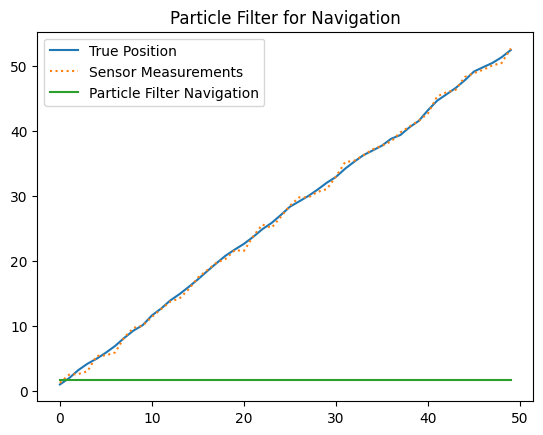

In [9]:
##########################
# Particle Filter for Navigation
##########################
pf_navigation_positions = particle_filter(true_positions, measurements)

plt.plot(true_positions, label="True Position")
plt.plot(measurements, label="Sensor Measurements", linestyle='dotted')
plt.plot(pf_navigation_positions, label="Particle Filter Navigation")
plt.legend()
plt.title("Particle Filter for Navigation")
plt.show()